# Lab 2: Spike Sorting with Deconvolution

**STATS320: Machine Learning Methods for Neural Data Analysis**

_Stanford University. Winter, 2021._

---

**Team Name:** Caulliflower Rice is a Scam

**Team Members:** Meg Richey, Nicholas Branigan, Shreyas Muralidharan, and Tom McIlwain

*Due: 11:59pm Thursday, Jan 28, 2021 via GradeScope (see below)*

---

This lab extends the basic spike sorting algorithm you developed in Lab 1. Rather than assuming putative spikes have been identified and windows around them have been extracted, here we'll model the multi-channel voltage time series directly using a convolutional matrix factorization model. We'll use PyTorch to implement the key operations&mdash;convolutions and cross-correlations&mdash;on a GPU. We'll test it on a small synthetic dataset first and then try it on the data from Lab 1.

# Environment Setup

In [ ]:
# First, import necessary libraries.
import numpy as np
import numpy.random
from scipy.signal import find_peaks
from scipy.optimize import linear_sum_assignment

# We'll use PyTorch for this lab
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions 

# Some helper utilities
from tqdm.auto import trange
import pickle

# Plotting stuff
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec
import seaborn as sns


In [ ]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda')
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

In [ ]:
#@title Helper functions for plotting (run this cell)

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])
sns.set_context("notebook")


def plot_data(timestamps,
              data, 
              plot_slice=slice(0, 6000), 
              labels=None, 
              spike_times=None,
              neuron_channels=None,
              spike_width=81,
              scale=10,
              figsize=(12, 9),
              cmap="jet"):
    n_channels, n_samples = data.shape
    cmap = get_cmap(cmap) if isinstance(cmap, str) else cmap
    
    plt.figure(figsize=figsize)
    plt.plot(timestamps[plot_slice], 
             data.T[plot_slice] - scale * np.arange(n_channels), 
             '-k', lw=1)
    
    if not any(x is None for x in [labels, spike_times, neuron_channels]):
        # Plot the ground truth spikes and assignments
        n_units = labels.max()
        in_slice = (spike_times >= plot_slice.start) & (spike_times < plot_slice.stop)
        labels = labels[in_slice]
        times = spike_times[in_slice]
        for i in range(n_units):
            i_channels = neuron_channels[i]
            for t in times[labels == i]:
                window = slice(t, t + spike_width)
                plt.plot(timestamps[window], 
                         data.T[window, i_channels] - scale * np.arange(n_channels)[i_channels],
                         color=cmap(i / (n_units-1)),
                         alpha=0.5,
                         lw=2)
                
    plt.yticks(-scale * np.arange(1, n_channels+1, step=2), 
            np.arange(1, n_channels+1, step=2) + 1)
    plt.xlabel("time [s]")
    plt.ylabel("channel")
    plt.xlim(timestamps[plot_slice.start], timestamps[plot_slice.stop])
    plt.ylim(-scale * n_channels, scale)


def plot_templates(templates, 
                   indices,
                   scale=0.1,
                   n_cols=8,
                   panel_height=6,
                   panel_width=1.25,
                   colors=('k',),
                   label="neuron",
                   sample_freq=30000,
                   fig=None,
                   axs=None):
    n_subplots = len(indices)
    n_cols = min(n_cols, n_subplots)
    n_rows = int(np.ceil(n_subplots / n_cols))

    if fig is None and axs is None:
        fig, axs = plt.subplots(n_rows, n_cols, 
                                figsize=(panel_width * n_cols, panel_height * n_rows),
                                sharex=True, sharey=True)
    
    n_units, n_channels, spike_width = templates.shape
    timestamps = np.arange(-spike_width // 2, spike_width//2) / sample_freq
    for i, (ind, ax) in enumerate(zip(indices, np.ravel(axs))):
        color = colors[i % len(colors)]
        ax.plot(timestamps * 1000, 
                templates[ind].T - scale * np.arange(n_channels), 
                '-', color=color, lw=1)
        
        ax.set_title("{} {:d}".format(label, ind + 1))
        ax.set_xlim(timestamps[0] * 1000, timestamps[-1] * 1000)
        ax.set_yticks(-scale * np.arange(n_channels+1, step=4))
        ax.set_yticklabels(np.arange(n_channels+1, step=4) + 1)
        ax.set_ylim(-scale * n_channels, scale)

        if i // n_cols == n_rows - 1:
            ax.set_xlabel("time [ms]")
        if i % n_cols == 0:
            ax.set_ylabel("channel")

        # plt.tight_layout(pad=0.1)

    # hide the remaining axes
    for ax in np.ravel(axs)[n_subplots:]:
        ax.set_visible(False)

    return fig, axs


def plot_model(templates, amplitude, data, scores=None, lw=2, figsize=(12, 6)):
    """Plot the raw data as well as the underlying signal amplitudes and templates.
    
    amplitude: (N,T) array of underlying signal amplitude
    template: (N,C,D) array of template that is convolved with signal
    data: (C, T) array (channels x time)
    scores: optional (N,T) array of correlations between data and template
    """    
    # prepend dimension if data and template are 1d
    data = np.atleast_2d(data)
    C, T = data.shape
    amplitude = np.atleast_2d(amplitude)
    N, _ = amplitude.shape
    templates = templates.reshape(N, C, -1)
    D = templates.shape[-1]
    dt = np.arange(D)
    if scores is not None:
        scores = np.atleast_2d(scores)

    # Set up figure with 2x2 grid of panels
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, N + 1, height_ratios=[1, 2], width_ratios=[1] * N + [2 * N])

    # plot the templates
    t_spc = 1.05 * abs(templates).max()
    for n in range(N):
        ax = fig.add_subplot(gs[1, n])
        ax.plot(dt, templates[n].T - t_spc * np.arange(C), 
                '-', color=palette[n % len(palette)], lw=lw)
        ax.set_xlabel("delay $d$")
        ax.set_xlim([0, D])
        ax.set_yticks(-t_spc * np.arange(C))
        ax.set_yticklabels([])
        ax.set_ylim(-C * t_spc, t_spc)
        if n == 0:
            ax.set_ylabel("channels $c$")
        ax.set_title("$W_{{ {} }}$".format(n+1))

    # plot the amplitudes for each neuron
    ax = fig.add_subplot(gs[0, -1])
    a_spc = 1.05 * abs(amplitude).max()
    if scores is not None:
        a_spc = max(a_spc, 1.05 * abs(scores).max())

    for n in range(N):
        ax.plot(amplitude[n] - a_spc * n, '-', color=palette[n % len(palette)], lw=lw)
        
        if scores is not None:
            ax.plot(scores[n] - a_spc * n, ':', color=palette[n % len(palette)], lw=lw,
                label="$y \star W$")
        
    ax.set_xlim([0, T])
    ax.set_xticklabels([])
    ax.set_yticks(-a_spc * np.arange(N))
    ax.set_yticklabels([])
    ax.set_ylabel("neurons $n$")
    ax.set_title("amplitude $a$")
    if scores is not None:
        ax.legend()

    # plot the data
    ax = fig.add_subplot(gs[1, -1])
    d_spc = 1.05 * abs(data).max()
    ax.plot(data.T - d_spc * np.arange(C), '-', color='gray', lw=lw)
    ax.set_xlabel("time $t$")
    ax.set_xlim([0, T])
    ax.set_yticks(-d_spc * np.arange(C))
    ax.set_yticklabels([])
    ax.set_ylim(-C * d_spc, d_spc)
    # ax.set_ylabel("channels $c$")
    ax.set_title("data $y$")

    # plt.tight_layout()

In [ ]:
#@title Helper function to generate synthetic data (run this cell)

def generate_templates(rng, C, D, N):
    # Make (semi) random templates
    templates = []
    for n in range(N):
        # center = n * C / (N - 1) if N > 1 else C / 2
        center = C * rng.random()
        width = 1 + (C / 10) * rng.random()
        spatial_factor = np.exp(-0.5 * (np.arange(C) - center)**2 / width**2)
        
        dt = np.arange(D)
        period = D / (1 + rng.random())
        z = (dt - 0.75 * period) / (.25 * period)
        warp = lambda x: -np.exp(-x) + 1
        window = np.exp(-0.5 * z**2)
        shape = np.sin(2 * np.pi * dt / period)
        temporal_factor = warp(window * shape)

        template = np.outer(spatial_factor, temporal_factor)
        template /= np.linalg.norm(template)
        templates.append(template)
    
    return np.array(templates)
    

def generate(rng, T, C, D, N, 
             mean_amplitude=15,
             shape_amplitude=3.0,
             noise_std=1, 
             sample_freq=1000):
    """Create a random set of model parameters and sample data.

    Parameters:
    T: integer number of time samples in the data
    C: integer number of channels
    D: integer duration (number of samples) of each template
    N: integer number of neurons
    """
    # Make semi-random templates
    templates = generate_templates(rng, C, D, N)

    # Make random amplitudes
    amplitudes = np.zeros((N, T))
    for n in range(N):
        num_spikes = rng.poisson(T / sample_freq * 10)
        times = rng.integers(0, T, size=num_spikes)
        amps = rng.gamma(shape_amplitude, 
                         scale=mean_amplitude / shape_amplitude, 
                         size=num_spikes)
        amplitudes[n, times] = amps

        # Only keep spikes separated by at least D
        times, props = find_peaks(amplitudes[n], distance=D, height=1e-3)
        amplitudes[n] = 0
        amplitudes[n, times] = props['peak_heights']

    # Convolve the signal with each row of the multi-channel template
    data = 0
    for temp, amp in zip(templates, amplitudes):
        data += np.row_stack([
            np.convolve(amp, row, mode='full')[:-(D-1)]
            for row in temp])
        
    data += rng.normal(scale=noise_std, size=data.shape)

    return templates, amplitudes, data

# Part 1: Convolution and cross-correlation with PyTorch

PyTorch is a machine learning framework for implementing fast numerical computations on CPU and GPU hardware. It has an interface very similar to NumPy's. Instead of numpy `ndarray` objects, we operate on PyTorch `Tensor` objects. Tensors are stored on the specified device, and in the setup above you'll see that we specified our device to be `'cuda'`, i.e. a GPU. That's also why you need to run this Colab notebook with a GPU Runtime. (If you click the RAM/disk icon in the upper right, you should see that this session is a GPU session. If it's not, go to "Runtime -> Change Runtime Type" to select a GPU.)

PyTorch `Tensor` objects have a similar interface to Numpy arrays. You can read all about them in the [docs](https://pytorch.org/docs/stable/tensors.html). In this notebook, we'll name our variables with `_t` suffixes to indicate that when they are a `Tensor`. We can convert back and forth between an `array` and a `Tensor` using the convenience functions `to_t` and `from_t`, which we defined above. (There are a few minor concerns in making the translation; for example, Numpy defaults to 64-bit floats whereas PyTorch defaults to 32-bit. Similarly, we have to make sure that we copy the tensor back to the CPU and "detach" it from the computation graph before converting it to a Numpy array.)

`Tensor` objects have a few nice functions that will make your life easier in this lab. Suppose `data_t` is a `Tensor`. Then,
- `data_t.flip(dims=(-1,))` flips the tensor along its last axis.
- `data_t.unsqueeze(0)` creates a new leading axis.
- `data_t.permute(1, 0, 2)` permutes the order of the axes.
- `data_t.reshape(1, 1, -1)` vectorizes the data and reshapes it to have two leading dimensions, each of length 1.
- `data_t.sum()` sums the entries in the data.

If this is your first time using PyTorch and you get stuck, you might want to check out some of their [tutorials](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html). 


## Problem 1a: Perform a 1d convolution

As a first step, we generate synthetic data with a single neuron and a single channel. Based on a template and a 1d array representing amplitudes for the single neuron, we simulate data as the convolution of these two arrays. 

You'll use the `conv1d` function in the `torch.nn.functional` package. We've already imported that package with the shorthand name `F` so that you can call the function with `F.conv1d(...)`. Take a look at its documentation [here](https://pytorch.org/docs/stable/nn.functional.html?highlight=conv1d#torch.nn.functional.conv1d), as well as the corresponding documentation for the `torch.nn.Conv1d` object, which implements a convolutional layer for a neural network. 

Here's an example,
```
# make the input (i.e. the signal)
B = 1   # batch size
N = 2   # number of input channels
T = 100 # length of input signal
input_t = torch.rand(B, N, T)

# make the weights (i.e. the filter)
C = 3   # number of output channels
D = 10  # length of the filter
weight_t = torch.rand(C, N, D)

# perform the convolution
output_t = F.conv1d(input_t, weight_t)

# output.shape is (B, C, T - D + 1)
```
**Remember that `conv1d` actually performs a cross-correlation!** 

Let $X \in \mathbb{R}^{B \times N \times T}$ denote the signal/input and $W \in \mathbb{R}^{C \times N \times D}$ denote the filter/weights (note that the axes are permuted relative to our templates), and let $Y \in \mathbb{R}^{B \times C \times T - D + 1}$ denote the output. Then the `conv1d` function implements the cross-correlation, 
\begin{align}
y_{b,c,t} = \sum_{n = 1}^{N} \sum_{d=1}^D x_{b,n,t+d-1} w_{c,n,d}.
\end{align}
for $b=1,\ldots,B$, $c=1,\ldots,C$, and $t=1,\ldots,T-D+1$. 

By default the output only contains the "valid" portion of the convolution; i.e. the $T-D+1$ samples where the inputs and weights completely overlap. If you want the "full" output, you have to call `F.conv1d(input_t, weights_t, padding=D-1)`. This pads the input with $D-1$ zeros at the beginning and end so that the resulting output is length $T + D - 1$. Depending your application, you may want the first $T$ or the last $T$ entries in this array. When in doubt, try both and see!

Use `conv1d` to implement a 1d **convolution**. Remember that you can do it by cross-correlation as long as you flip your weights along the last axis. 

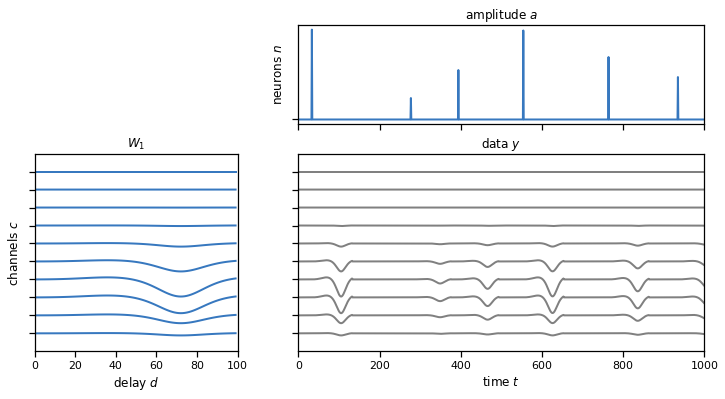

In [ ]:
# Create a dataset with a single channel and one neuron.
T = 1000    # number of time samples
C = 10      # number of channels
D = 100     # duration of a spike (in samples)
N = 1       # one neuron

# Generate random templates, amplitudes, and noisy data.
# `templates` are NxCxD and `amplitudes` are NxT
rng = np.random.default_rng(seed=0)
templates, amplitudes, _ = generate(rng, T, C, D, N)

# Convolve the signal with each row of the multi-channel tempalte
data = np.row_stack([
    np.convolve(amplitudes[0], row, mode='full')[:T]
    for row in templates[0]])

plot_model(templates, amplitudes, data)

###
# Now perform the same convolution using PyTorch's `conv1d` function.
#
# YOUR CODE BELOW
#
amplitudes_t = to_t(amplitudes)
templates_t = to_t(templates)
data_t = F.conv1d(amplitudes_t.unsqueeze(0),templates_t.permute(1,0,2).flip(2),padding=D-1)[:,:,:1000]

#
### 

assert np.allclose(data, from_t(data_t))

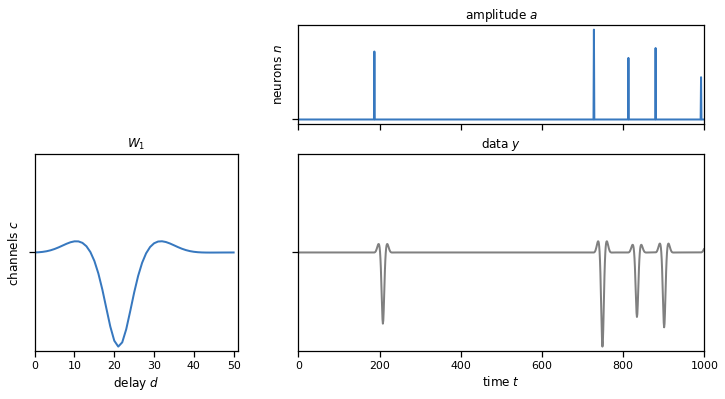

In [ ]:
# Create a dataset with a single channel and one neuron.
T = 1000    # number of time samples
N = 1       # one neuron
C = 1       # number of channels
D = 51      # duration of a spike (in samples)

# Generate random templates, amplitudes, and noisy data.
# `templates` are NxCxD and `amplitudes` are NxT
rng = np.random.default_rng(seed=2)
templates, amplitudes, _ = generate(rng, T, C, D, N)

# Convolve the amplitude with the template using numpy.
data = np.convolve(amplitudes[0], templates[0, 0], mode='full')[:T]

# Plot the templates, amplitude, and data
plot_model(templates, amplitudes, data)

###
# Now perform the same convolution using PyTorch's `conv1d` function.
#
# YOUR CODE BELOW
amplitudes_t = to_t(amplitudes)
templates_t = to_t(templates)
data_t = F.conv1d(amplitudes_t.unsqueeze(0),templates_t.permute(1,0,2).flip(2),padding=D-1)
data_t_check=data_t[0,0,0:1000]
#
### 

assert np.allclose(data, from_t(data_t_check))

## Problem 1b: Perform a 1d cross-correlation in PyTorch

Recall from class that the cross-correlation measures the similarity between the template and the actual data at every time window. In those time points where the data and the template coincide, we should obtain a high correlation indicating the presence of a spike. The peaks of the amplitude array and the cross-correlation array should match, as you see in the plot below.  The dotted line shows the cross-correlation of the data and the template, and we see that it peaks where there are spikes in the true underlying amplitude that generated the data. 

Use `conv1d` to implement this **cross-correlation** and get the dotted line. 

torch.Size([1, 1, 1050])


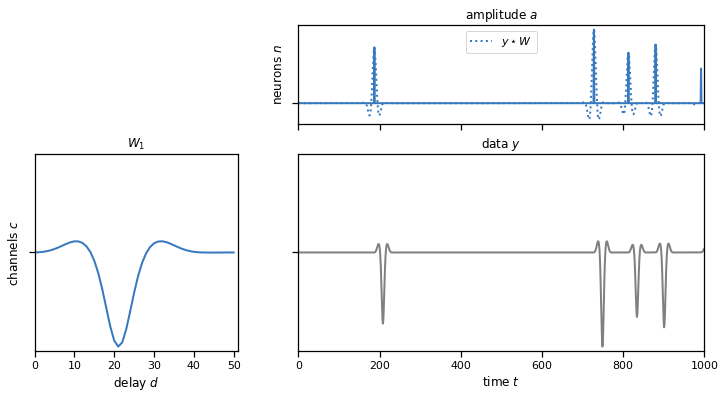

In [ ]:
# Now correlate the data with the template to estimate spike times
score = np.correlate(data, templates[0, 0], mode='full')[D-1:]
assert score.shape[0] == T

plot_model(templates, amplitudes, data, scores=score)


print(data_t.shape)
###
# Now perform the same cross-correlation using PyTorch's `conv1d` function.
#
# YOUR CODE BELOW
score_t = F.conv1d(data_t[:,:,:1000],templates_t.permute(1,0,2),padding=D-1)[0,0,D-1:]

#
### 

assert np.allclose(score, from_t(score_t))

## Problem 1c: Perform a 1d convolution across multiple channels at once

Similar to problem 1a, except that the template (and therefore the final synthetic data) has multiple _output_ channels.

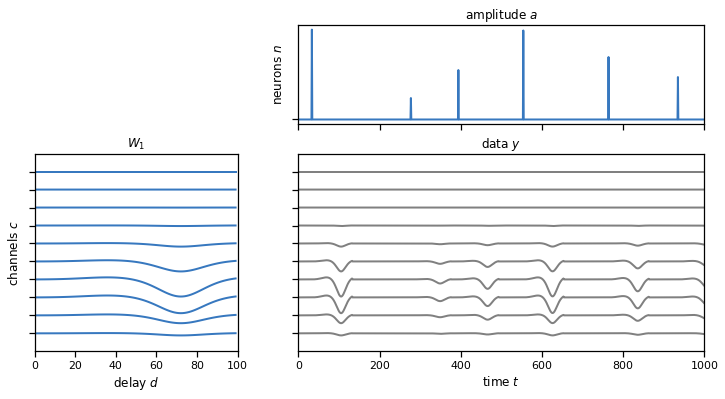

In [ ]:
# Create a dataset with a single channel and one neuron.
T = 1000    # number of time samples
C = 10      # number of channels
D = 100     # duration of a spike (in samples)
N = 1       # one neuron

# Generate random templates, amplitudes, and noisy data.
# `templates` are NxCxD and `amplitudes` are NxT
rng = np.random.default_rng(seed=0)
templates, amplitudes, _ = generate(rng, T, C, D, N)

# Convolve the signal with each row of the multi-channel tempalte
data = np.row_stack([
    np.convolve(amplitudes[0], row, mode='full')[:T]
    for row in templates[0]])

plot_model(templates, amplitudes, data)

###
# Now perform the same convolution using PyTorch's `conv1d` function.
#
# YOUR CODE BELOW
#
amplitudes_t = to_t(amplitudes)
templates_t = to_t(templates)
data_t = F.conv1d(amplitudes_t.unsqueeze(0),templates_t.permute(1,0,2).flip(2),padding=D-1)[:,:,0:1000]

#
### 

assert np.allclose(data, from_t(data_t))

## Problem 1d: Perform a 1d cross-correlation across multiple channels at once

Same as Problem 1b except that the data and templates have multiple _input_ channels.

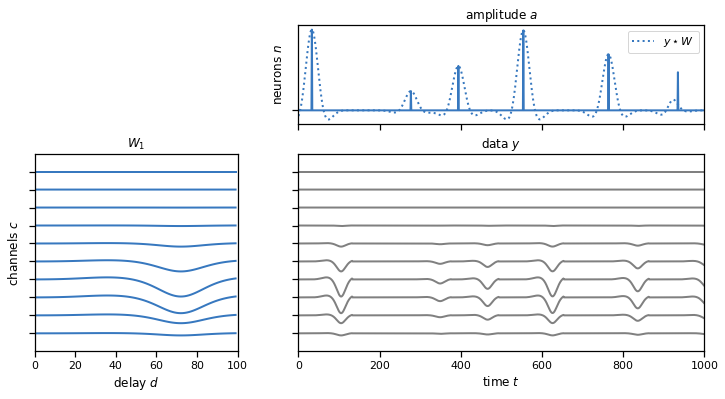

In [ ]:
# We'll first perform the cross-correlation in numpy by correlating
# each row of the data with the corresponding row of the template and summing.
# Then you'll do the same thing in PyTorch using a single call to `F.conv1d`.
score = np.sum([np.correlate(data[c], templates[0, c], mode='full')[D-1:]
                for c in range(C)], axis=0)

plot_model(templates, amplitudes, data, scores=score)

###
# Now perform the same cross-correlation using PyTorch's 
# ``nn.functional.conv1d` function. You should only need 
# one call to this function!
#
# YOUR CODE BELOW
score_t = F.conv1d(data_t,templates_t.permute(0,1,2),padding=D-1)[:,:,D-1:]
### 

assert np.allclose(score, from_t(score_t))

## Problem 1e: Convolving multiple neurons' spikes and templates

Similar to problem 1c, but here we have multiple neurons (input channels), each associated to a template with multiple (output) channels. The final simulated data is aggregated across neurons to simulate actual measurements where signals from multiple neurons are superimposed.

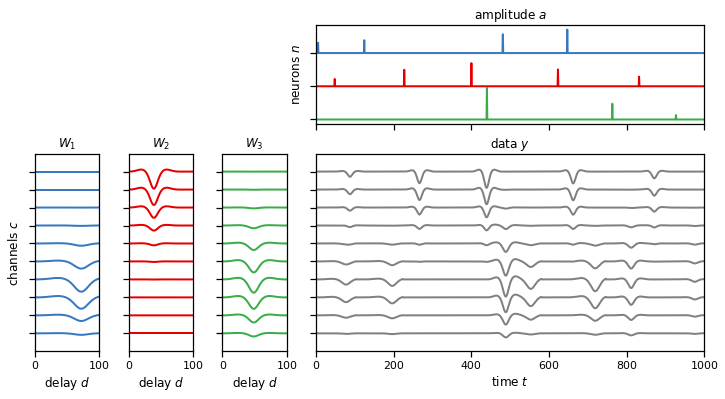

In [ ]:
# Create a dataset with a multiple channels and neurons.
T = 1000    # number of time samples
C = 10      # number of channels
D = 100     # duration of a spike (in samples)
N = 3       # multiple neuron

# Generate random templates, amplitudes, and noisy data.
# `templates` are NxCxD and `amplitudes` are NxT
rng = np.random.default_rng(seed=0)
templates, amplitudes, _ = generate(rng, T, C, D, N)

# Convolve the signal with each row of the multi-channel template
data = 0
for temp, amp in zip(templates, amplitudes):
    data += np.row_stack([
        np.convolve(amp, row, mode='full')[:T]
        for row in temp])

plot_model(templates, amplitudes, data)

###
# Now perform the convolution using PyTorch's `conv1d` function. 
# One call to `F.conv1d` should perform the sum over neurons for you.
#
# YOUR CODE BELOW
#
templates_t = to_t(templates)
amplitudes_t = to_t(amplitudes)
data_t = F.conv1d(amplitudes_t.unsqueeze(0),templates_t.permute(1,0,2).flip(2),padding=D-1)[:,:,:1000]

#
###
assert np.allclose(data, from_t(data_t))

## Problem 1f: Perform a 1d cross-correlation across multiple channels and neurons at once

Same as Problem 1c but now we're performing the cross-correlation with multiple neurons' templates at once.

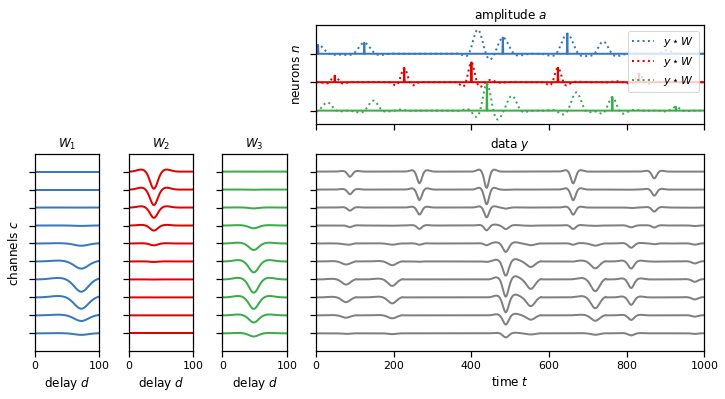

In [ ]:
# We'll first perform the cross-correlation in numpy by correlating
# each row of the data with the corresponding row of each template and summing.
# Then you'll do the same thing in PyTorch using a single call to `F.conv1d`.
score = np.array([
    np.sum([np.correlate(data[c], templates[n, c], mode='full')[D-1:]
            for c in range(C)], axis=0)
    for n in range(N)])

plot_model(templates, amplitudes, data, scores=score)

###
# Now perform the convolution using PyTorch's `conv1d` function. 
# One call to `F.conv1d` should perform all cross-correlations for you.
#
# YOUR CODE BELOW
score_t = F.conv1d(data_t,templates_t.permute(0,1,2),padding=D-1)[:,:,D-1:]

#
###

assert np.allclose(score, from_t(score_t), atol=1e-4)

# Part 2: Spike sorting by deconvolution

In this part of the lab you'll use those cross-correlation and convolution operations to implement the spike sorting algorithm we discussed in class. We'll work with a synthetic dataset, as above, but this time we'll make it slightly larger.  (It's still a lot smaller than the dataset we used in Lab 1 though!)

## Simulate some data

No coding necessary here. We're just simulating the data for you.

Simulating data. This could take a minute!


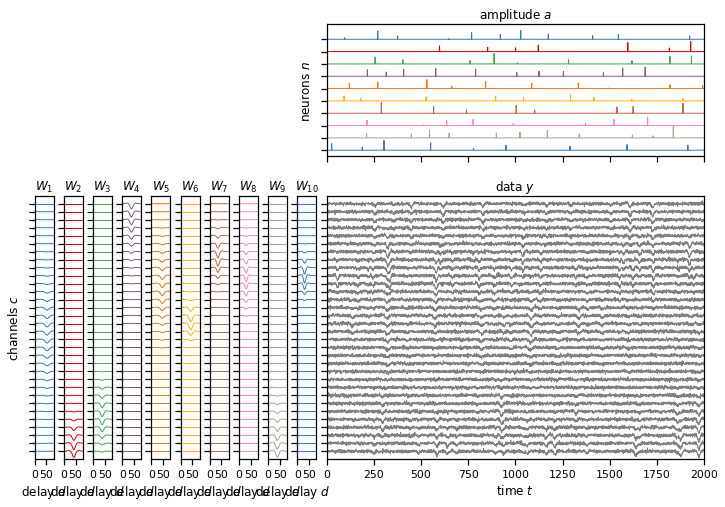

In [ ]:
# Create a larger dataset with a multiple channels and neurons.
T = 1000000 # number of time samples
C = 32      # number of channels
D = 81      # duration of a spike (in samples)
N = 10      # multiple neurons

# Generate random templates, amplitudes, and noisy data.
# `templates` are NxCxD and `amplitudes` are NxT
rng = np.random.default_rng(seed=1)
print("Simulating data. This could take a minute!")
true_templates, true_amplitudes, data = generate(rng, T, C, D, N)
plot_model(true_templates, true_amplitudes[:, :2000], data[:,:2000], lw=1, figsize=(12, 8))

In [ ]:
# Generate another set of random templates and amplitudes to seed the model
rng = np.random.default_rng(seed=1)
templates = generate_templates(rng, C, D, N)
amplitudes = np.zeros((N, T))
noise_std = 1.0

# Copy to the device
templates_t = to_t(templates)
amplitudes_t = to_t(amplitudes)
data_t = to_t(data)

## Problem 2a: Compute the log likelihood

One of the most awesome features of PyTorch is its `torch.distributions` package. See the docs [here](https://pytorch.org/docs/stable/distributions.html). It contains objects for many of our favorite distributions, and has convenient functions for computing log probabilities (with `d.log_prob()` where `d` is a `Distribution` object), sampling (`d.sample()`), computing the entropy (`d.entropy()`), etc. These functions broadcast as you'd expect (unlike `scipy.stats`!), and they're designed to work with automatic differentiation.  More on that another day...

For now, you'll use `torch.distributions.Normal` to compute the log likelihood of the data given the template and amplitudes, $\log p(Y \mid A, W)$.  To do that, you'll convolve the amplitudes and templates (recall Problem 1e) to get the mean value of $Y$, then you'll use the `log_prob` function to evaluate the likelihood of the data.

In [ ]:
def log_likelihood(templates_t, amplitudes_t, data_t, noise_std):
    """Evaluate the log likelihood"""
    N, C, D = templates_t.shape
    _, T = data_t.shape
    
    ### 
    # Compute the log probability 
    #
    # YOUR CODE BELOW
    
    # Compute the model predictions by convolving the amplitude and templates
    pred_t = F.conv1d(amplitudes_t.unsqueeze(0),templates_t.permute(1,0,2).flip(2),padding=D-1)[:,:,:T]

    # Evaluate the log probability using torch.distributions.Normal
    d = torch.distributions.Normal(pred_t,noise_std)
    lp=d.log_prob(data_t).sum()
    #
    ###

    # Return the log probability normalized by the data size
    return lp / (C * T)

ll = log_likelihood(templates_t, amplitudes_t, data_t, noise_std)
assert ll.isclose(to_t(-1.7955), atol=1e-4)

## Problem 2b: Compute the residual

Next, compute the residual for a specified neuron by subtracting the convolved amplitudes and templates for all the other neurons. Again, recall Problem 1e.

In [ ]:
def compute_residual(neuron, templates_t, amplitudes_t, data_t):
    N, C, D = templates_t.shape

    ###
    # Compute the predicted value of the data by 
    # convolving the amplitudes and the templates for all
    # neurons except the specified one.
    #
    # YOUR CODE BELOW
    not_n = np.concatenate([np.arange(neuron), np.arange(neuron+1, N)])

    amplitudes_t=torch.cat((amplitudes_t[:neuron,:],amplitudes_t[neuron+1:,:]),axis=0)
    templates_t=torch.cat((templates_t[:neuron,:,:],templates_t[neuron+1:,:,:]),axis=0)

    #NOTE FROM OH. CORRECT BUT REDUNDANT
    #amplitudes_t[not_n]

    pred_t = F.conv1d(amplitudes_t.unsqueeze(0),templates_t.permute(1,0,2).flip(2),padding=D-1)[:,:,:-(D-1)]
    ###
    #CHANGED HERE IN OH

    # Return the data minus the predicted value given other neurons
    return data_t - pred_t

residual_t = compute_residual(0, templates_t, amplitudes_t, data_t)
print(residual_t)

tensor([[[ 0.3435,  0.5171,  1.9433,  ..., -0.3349,  1.6980,  1.4173],
         [ 0.8453, -0.6903,  0.5293,  ..., -0.5159, -0.9678,  0.1766],
         [ 1.3856,  1.8921,  0.7543,  ...,  0.4865,  0.7541,  0.0830],
         ...,
         [-1.4304, -1.1572,  1.2561,  ..., -1.6143,  0.6912, -1.3811],
         [-0.2236,  0.3136, -0.8930,  ..., -0.0539,  0.3991, -3.0690],
         [ 0.9101,  0.1401,  0.6817,  ...,  2.0164, -0.1754, -1.8387]]],
       device='cuda:0')


## Problem 2c: Compute the score

We defined the "score" for neuron $n$ to be the cross-correlation of the residual and its template. Compute it using `conv1d`. Recall Problem 1d.

In [ ]:
def compute_score(neuron, templates_t, amplitudes_t, data_t):
    N, C, D = templates_t.shape
    T = data_t.shape[1]

    # First get the residual
    residual_t = compute_residual(neuron, templates_t, amplitudes_t, data_t)

    ###
    # Compute the 'score' by cross-correlating the residual
    # and the template for this neuron.
    #
    # YOUR CODE BELOW
    score_t = F.conv1d(residual_t,templates_t[neuron,:,:].unsqueeze(0),padding=D-1)[:,:,D-1:]
   
    #
    ###
    return score_t

## Problem 2d: Update the amplitudes using `find_peaks`

Our next step is to update the amplitudes given the scores. We'll use the simple heuristic described in lecture to find peaks in the score that are separated by a distance of at least $D$ samples and at least a height of $\sigma^2 \lambda$, where $\sigma$ is the standard deviation of the noise and $\lambda$ is the amplitude rate hyperparameter. Use the `find_peaks` function from Lab 1 to do this, and then update the amplitude tensor with your results

In [ ]:
def _update_amplitude(neuron, templates_t, amplitudes_t, data_t, noise_std=1.0, amp_rate=5.0):
    N, C, D = templates_t.shape
    T = data_t.shape[1]

    # Compute the score and convert it to a numpy array.
    score_t = compute_score(neuron, templates_t, amplitudes_t, data_t)
    score = from_t(score_t)
    amplitudes_t[neuron] = 0

    ###
    # Find the peaks in the cross-correlation and update the amplitude tensor.
    #
    # YOUR CODE BELOW
    peaks, props = find_peaks(score[0,0,:],height=noise_std**2*amp_rate,distance=D)
    #TOOK OUT MINUS IN OH- max not minus
    heights = props['peak_heights']

    # Update the amplitude tensor for this neuron.
    # ...
    amplitudes_t[neuron,peaks]=to_t(heights)
    #
    ###

## Problem 2e: Update the templates 
Our last step is to update the template for a given neuron by projecting the _target_ $\overline{R}_n \in \mathbb{R}^{C \times D}$. The target is the sum of scaled residuals at the times of spikes in the amplitudes:
\begin{align}
    \overline{R}_n = \sum_{t:a_{nt} > 0} a_{nt} R_{n,:,t:t+D}.
\end{align}
where $R_n \in \mathbb{R}^{C \times T}$ denotes the residual for neuron $n$. 

In lecture we suggested a simple trick to implement this summation. First compute a matrix of regressors $X_n \in \mathbb{R}^{D \times T}$ where the $d$-th row is equal to the lagged amplitudes. That is,
\begin{align}
x_{ndt} = a_{n,t-d+1}.
\end{align}
We can equivalently compute the regressor matrix by convolving the amplitudes with a "delay" matrix, which is just the $D \times D$ identity matrix.

Once we have the regressors, we can compute the target as $\overline{R}_n = R_n X_n^\top$.

Finally, to get the template, project $\overline{R}_n$ onto $\mathcal{S}_K$, the set of rank-$K$, unit-norm matrices, using the SVD. 

In [ ]:
def _update_template(rng, neuron, templates_t, amplitudes_t, data_t, template_rank=1):
    N, C, D = templates.shape
    T = data_t.shape[1]


    # Check if the factor is used. If not, generate a random new one.
    if amplitudes_t[neuron].sum() < 1:
        target_t = to_t(generate_templates(rng, C, D, 1)[0])

    else:
        ###
        # Make a TxD array of regressors for this neuron
        # by convolving its amplitude with a "delay" matrix;
        # i.e. a DxD identity matrix. 
        #
        # YOUR CODE BELOW
        delay_t = to_t(np.eye(D))
        regressors_t = F.conv1d(amplitudes_t[neuron].reshape(1,1,T),delay_t.unsqueeze(1).flip(dims=(2,)),padding=D-1)[:,:,:T]

        #ADDED AN UNSQUEEZE IN OH ADD, changed DIM to 2 and added flip, [:,:,:T]
        
        # Get the residual using the function you wrote above
        residual_t = compute_residual(neuron, templates_t, amplitudes_t, data_t)

        # Compute the target (inner product of residual and regressors)
        
        
        target_t = residual_t[0] @ regressors_t[0].T
        

        #changed dimensions and used .T instead
        ###


    ###
    # Project the target onto the set of normalized rank-K templates using 
    # `torch.svd` and `torch.norm`. Note that `torch.svd` returns V rather 
    # than V^T, as `np.linalg.svd` does.
    #
    # YOUR CODE BELOW
    Un_t, Sn_t, Vn_t = torch.svd(target_t)
    templates_t[neuron] = (Un_t[:,:template_rank] * Sn_t[:template_rank] / torch.linalg.norm(Sn_t[:template_rank])) @ Vn_t[:,:template_rank].T    # added .T instead of transpose and deleted .linalg
    ###



## Put it all together

That's it! We've written a little function to perform coordinate ascent using your `_update_*` functions. It tracks the log likelihood at each iteration. (We're ignoring the priors for now, but it would be easy to compute those in Problem 2a if you wanted to). It also uses some nice progress bars so you can see how fast (or slow?) your code runs.

In [ ]:
def map_estimate(rng,
                 templates_t, 
                 amplitudes_t, 
                 data_t,
                 num_iters=20, 
                 template_rank=1,
                 noise_std=1.0, 
                 amp_rate=5.0,
                 tol=1e-4):
    """Fit the templates and amplitudes by maximum a posteriori (MAP) estimation.
    """
    N, C, D = templates_t.shape

    # Make fancy reusable progress bars
    outer_pbar = trange(num_iters)
    inner_pbar = trange(N)
    inner_pbar.set_description("updating neurons")

    # Track log likelihoods over iterations
    lls = [from_t(log_likelihood(templates_t, amplitudes_t, data_t, noise_std=noise_std))]
    for itr in outer_pbar:
        inner_pbar.reset()
        for n in range(N):
            # Update the amplitude
            _update_amplitude(n, templates_t, amplitudes_t, data_t, noise_std=noise_std, amp_rate=amp_rate)    
            # Update the template
            _update_template(rng, n, templates_t, amplitudes_t, data_t, template_rank=template_rank)
            inner_pbar.update()

        # Compute the log likelihood 
        lls.append(from_t(log_likelihood(templates_t, amplitudes_t, data_t, noise_std=noise_std)))

        # Check for convergence
        if abs(lls[-1] - lls[-2]) < tol:
            print("Convergence detected!")
            break
    
    return np.array(lls)

## Fit the synthetic data and plot the log likelihoods

Convergence detected!


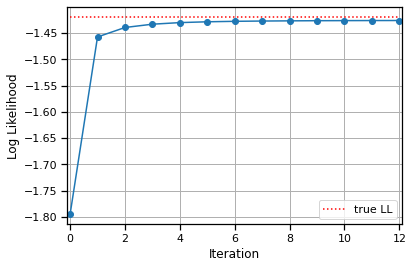

In [ ]:
# Make random templates and set amplitude to zero
rng = np.random.default_rng(seed=1)
templates = generate_templates(rng, C, D, N)
amplitudes = np.zeros((N, T))
noise_std = 1.0     # \sigma
amp_rate = 5.0      # \lambda

# Copy to the device
templates_t = to_t(templates)
amplitudes_t = to_t(amplitudes)
data_t = to_t(data)

# Fit the model.
lls = map_estimate(rng, templates_t, amplitudes_t, data_t, noise_std=noise_std, amp_rate=amp_rate)

# For comparison, compute the log likelihood with the true templates and amplitudes.
true_ll = from_t(log_likelihood(to_t(true_templates),
                                to_t(true_amplitudes),
                                data_t,
                                noise_std))

# Plot the log likelihoods
plt.plot(lls, '-o')
plt.hlines(true_ll, 0, len(lls) - 1, colors='r', linestyles=':', label="true LL")
plt.xlabel("Iteration")
plt.xlim(-.1, len(lls) - .9)
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.legend(loc="lower right")

## Find a permutation of the inferred neurons that best matches the true neurons

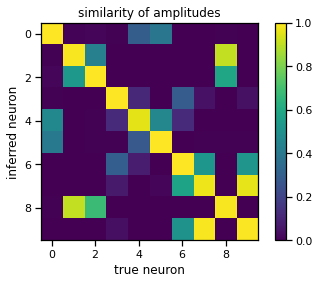

In [ ]:
# Compute the similarity (inner product) of the true and inferred templates
templates = from_t(templates_t)
similarity = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        similarity[i, j] = np.sum(true_templates[i] * templates[j])
        
# Show the similarity matrix
_, perm = linear_sum_assignment(similarity, maximize=True)
plt.imshow(similarity[:, perm], vmin=0, vmax=1)
plt.xlabel("true neuron")
plt.ylabel("inferred neuron")
plt.title("similarity of amplitudes")
plt.colorbar()

## Plot the true and inferred templates

They should line up pretty well.

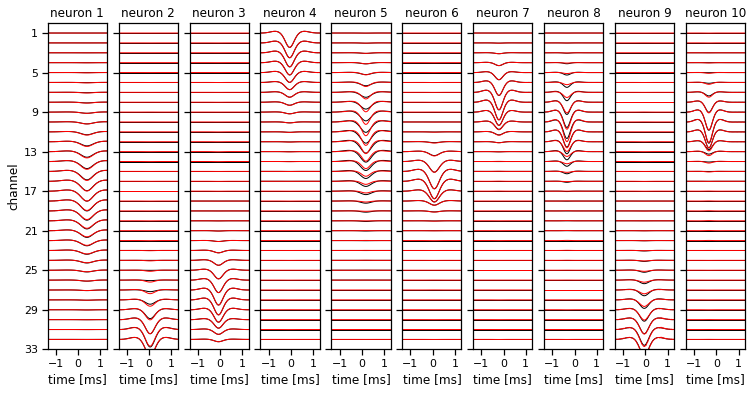

In [ ]:
# Plot the true and inferred templates, permuted to best match
fig, axs = plot_templates(true_templates, np.arange(N), n_cols=N)
_ = plot_templates(templates[perm], np.arange(N), 
                   n_cols=N, colors=('r',), fig=fig, axs=axs)

# Part 3: Now do it more efficiently

Our code above was not optimized for efficiency. For example, we kept recomputing the residual, which incurred costly convolutions. Likewise, we naively cross-correlated the residual with the templates, without leveraging the fact that the templates are low rank. In this section you'll go back and address these shortcomings.

## Problem 3a: Write helper functions to up/down-date the residual

Each iteration of `map_estimate` updates one neuron at a time. We can save a lot of computation by just adding and subtracting that neuron's convolved template from the residual at the start and end of the iteration. Moreover, we can perform that convolution more efficiently by working directly with the factors of the template. 

Let $W_n = U_n \tilde{V}_n^\top$ where $\tilde{V}_n^\top = \mathrm{diag}(\varsigma_n) V_n^\top \in K \times D$ denotes the weighted temporal factors of neuron $n$'s template. We can use this factorization to implement the convolution as,
\begin{align}
a_n \circledast W_n = U_n (a_n \circledast \tilde{V}_n^\top)
\end{align}
In code, we'll let `U_t` denote the tensor of spatial factors. It is of shape $N \times C \times K$ so that `U_t[n]` corresponds to $U_n$ in our equations above. Likewise, let `weighted_VT_t` denote the tensor of weighted temporal factors.  It is of shape $N \times K \times D$ so that `weighted_VT_t[n]` corresponds to $\tilde{V}_n^\top$. 

In [ ]:
def update_residual(neuron, U_t, weighted_VT_t, amplitudes_t, residual_t):
    """
    Add the specified neurons' template convolved with its amplitude to the residual.
    """
    N, C, K = U_t.shape
    _, _, D = weighted_VT_t.shape
    _, T = data_t.shape

    ###
    # Convolve this neuron's amplitude with its weighted temporal factor.
    # Project the result using the neuron's channel factor.
    # Add that result to the residual.
    #
    # YOUR CODE BELOW
    
    
    residual_t += U_t[neuron,:,:] @ F.conv1d(amplitudes_t[neuron,:].unsqueeze(0).unsqueeze(1), weighted_VT_t[neuron,:,:].unsqueeze(0).flip(dims=(2,)), padding=D-1)[:,:,:T].squeeze(0)
    #
    ###

def downdate_residual(neuron, U_t, weighted_VT_t, amplitudes_t, residual_t):
    """
    Subtract the specified neurons' template convolved with its amplitude to the residual.
    """
    N, C, K = U_t.shape
    _, _, D = weighted_VT_t.shape
    _, T = data_t.shape

    ###
    # Convolve this neuron's amplitude with its weighted temporal factor.
    # Project the result using the neuron's channel factor.
    # Subtract that result to the residual.
    #
    # YOUR CODE BELOW
    #Un_t, Sn_t, Vn_t = torch.svd(weighted_VT_t)
    residual_t -= U_t[neuron,:,:]@F.conv1d(amplitudes_t[neuron,:].unsqueeze(0).unsqueeze(1), weighted_VT_t[neuron,:,:].unsqueeze(0).flip(dims=(2,)),padding=D-1)[:,:,:T].squeeze(0)
    #
    ###


## Problem 3b: Update the amplitudes using a fast score calculation

In lecture we showed that the score&mdash;the cross correlation of the residual and a template&mdash; can be computed more efficiently by projecting the residual on the spatial factors of the template and then convolving with the weighted temporal factors. In math,
\begin{align}
R_n \star W_n &= (U_n^\top R_n) \star \tilde{V}_n^\top.
\end{align}
Re-implement your `update_amplitude` function from above, but this time compute the score by projecting and convolving the residual. 

In [ ]:
def _update_amplitude_fast(neuron, U_t, weighted_VT_t, amplitudes_t, residual_t, 
                           noise_std=1.0, amp_rate=5.0):
    D = weighted_VT_t.shape[2]

    ###
    # compute the score by projecting the residual (U_n^T R_n)
    # and cross-correlating with the weighted temporal factor (V_n^T)
    # 
    # YOUR CODE BELOW
    
    # project the residual onto the channel factor for this neuron
    #print(U_t.shape)
    #print(weighted_VT_t.shape)

    proj_residual_t = U_t[neuron,:,:].T @ residual_t   
    
    # correlate the projected residual with the weighted temporal factor
    #print(proj_residual_t.shape)
    score_t = F.conv1d(proj_residual_t.unsqueeze(0), weighted_VT_t[neuron,:,:].unsqueeze(0),padding=D-1)[:,:,D-1:]
    
    # Find the peaks in the cross-correlation
    score = from_t(score_t)
    peaks, props = find_peaks(score[0,0,:],height=noise_std**2*amp_rate,distance=D)
    heights = props['peak_heights']

    # Update the amplitudes for this neuron in place
    amplitudes_t[neuron] = 0
    amplitudes_t[neuron,peaks]=to_t(heights)
    
    #
    ###
        

## Problem 3c: Update the low rank factors of the template

Finally, copy your answer from Problem 2e to update the templates, but this time just keep the template factors $U_n$ and $\tilde{V}_n^\top$.

In [ ]:
import sys
def _update_template_factors(rng, neuron, U_t, weighted_VT_t, amplitudes_t, residual_t, template_rank=1):
    N, C, D = templates.shape
    T = residual_t.shape[1]

    # Check if the factor is used. if not, generate a random new one.
    if amplitudes_t[neuron].sum() < 1:
        target_t = to_t(generate_templates(rng, C, D, 1)[0])
    else:
        # Make the regressors (i.e. a TxD matrix of delayed amplitudes) for this neuron 
        delay_t = torch.eye(D, device=device, dtype=dtype)

        ###
        # Compute the matrix of regressors by convolving the amplitude and the delay
        # as in Problem 2e.
        #
        # YOUR CODE BELOW
        regressors_t = F.conv1d(amplitudes_t[neuron].reshape(1,1,T),delay_t.unsqueeze(1).flip(dims=(2,)),padding=D-1)[:,:,:T]
        
        # Compute the target (inner product of residual and regressors)
        
        target_t = residual_t @ regressors_t[0,:,:].T
        
        #
        ###

    ###
    # Project the target onto the set of normalized rank-K templates
    # and keep only the spatial factors (U_n) and the weighted temporal
    # factors (V_n^T)
    # 
    # YOUR CODE BELOW
    Un_t, Sn_t, Vn_t = torch.svd(target_t)

    # Truncate and normalize the singular values
    Sn_t = Sn_t[:template_rank] / torch.linalg.norm(Sn_t[:template_rank])
    # Truncate, weight, and transpose the factors as appropriate
    U_t[neuron] = Un_t[:,:template_rank]
    weighted_VT_t[neuron] = Sn_t*Vn_t[:,:template_rank].T
    #
    ###

## Put it all together

Now we'll write another function to perform MAP estimation using your new-and-improved code. We've got to do a little work to initialize the residuals and the templates, but it's all pretty straightforward.

In [ ]:
def map_estimate_fast(rng,
                      templates_t, 
                      amplitudes_t, 
                      data_t,
                      num_iters=20, 
                      template_rank=1,
                      noise_std=1.0, 
                      amp_rate=5.0,
                      tol=1e-4):
    """Fit the templates and amplitudes by maximum a posteriori (MAP) estimation.
    """
    N, C, D = templates_t.shape

    # Make a fancy reusable progress bar for the inner loops over neurons.
    outer_pbar = trange(num_iters)
    inner_pbar = trange(N)
    inner_pbar.set_description("updating neurons")

    # Initialize the residual
    residual_t = data_t - F.conv1d(amplitudes_t.unsqueeze(0),
                                   templates_t.permute(1, 0, 2).flip(dims=(2,)),
                                   padding=D-1)[0, :, :-(D-1)]

    # Initialize the template factors
    U_t, S_t, V_t = torch.svd(templates_t)
    U_t, S_t, V_t = U_t[..., :template_rank], S_t[..., :template_rank], V_t[..., :template_rank]
    weighted_VT_t = V_t * S_t.unsqueeze(1)
    weighted_VT_t = weighted_VT_t.permute(0, 2, 1)

    # Track log likelihoods over iterations
    lls = [from_t(log_likelihood(templates_t, amplitudes_t, data_t, noise_std=noise_std))]

    # Coordinate ascent
    for itr in outer_pbar:

        # Update neurons one at a time
        inner_pbar.reset()
        for n in range(N):
            # Update the residual (add a_n \circledast W_n)
            update_residual(n, U_t, weighted_VT_t, amplitudes_t, residual_t)
    
            # Update the template and amplitude with the residual
            _update_amplitude_fast(n, U_t, weighted_VT_t, amplitudes_t, residual_t, 
                                   noise_std=noise_std, amp_rate=amp_rate)
            
            _update_template_factors(rng, n, U_t, weighted_VT_t, amplitudes_t, residual_t, 
                                     template_rank=template_rank)
    
            # Downdate the residual (subtract a_n \circledast W_n)
            downdate_residual(n, U_t, weighted_VT_t, amplitudes_t, residual_t)

            # Step the progress bar
            inner_pbar.update()

        # Reconstruct the templates in place
        templates_t[:] = U_t @ weighted_VT_t

        # Compute the log likelihood 
        lls.append(from_t(log_likelihood(templates_t, amplitudes_t, data_t, noise_std=noise_std)))

        # Check for convergence
        if abs(lls[-1] - lls[-2]) < tol:
            print("Convergence detected!")
            break
    
    return np.array(lls)

## Run it on the synthetic data

Convergence detected!
[-1.7955338 -1.4574125 -1.4393817 -1.4331008 -1.4300764 -1.4285042
 -1.4276161 -1.427079  -1.4267228 -1.426441  -1.4262887 -1.4261631
 -1.4260771]
[-1.7955338 -1.4574118 -1.4393816 -1.4331019 -1.4300776 -1.4285042
 -1.4276153 -1.427081  -1.4267272 -1.4264548 -1.426296  -1.4261743
 -1.4260806]


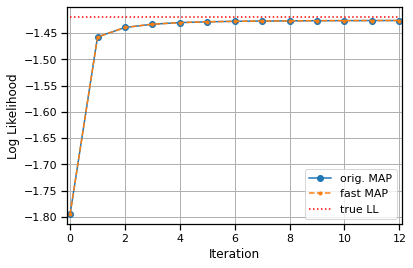

In [ ]:
# Make random templates and set amplitude to zero
rng = np.random.default_rng(seed=1)
templates = generate_templates(rng, C, D, N)
amplitudes = np.zeros((N, T))
noise_std = 1.0
amp_rate = 5.0

# Copy to the device
templates_t = to_t(templates)
amplitudes_t = to_t(amplitudes)
data_t = to_t(data)

# Fit the model.
fast_lls = map_estimate_fast(rng, templates_t, amplitudes_t, data_t, 
                             noise_std=noise_std, amp_rate=amp_rate)

# Plot the log likelihoods from the fast code on top of those from the original code
# They should like up exactly since we used the same initial condition.
plt.plot(lls, '-o', label="orig. MAP")
plt.plot(fast_lls, '--.', label="fast MAP")
plt.hlines(true_ll, 0, len(lls) - 1, colors='r', linestyles=':', label="true LL")
plt.xlabel("Iteration")
plt.xlim(-.1, len(lls) - .9)
plt.ylabel("Log Likelihood")
plt.grid(True)
plt.legend(loc="lower right")
print(lls)
print(fast_lls)
assert np.allclose(lls, fast_lls, atol=1e-4)

# Part 4: Try it on the data from Lab 1

Last but not least, let's try it on the data from last week's lab! This is a bit larger: 3.6x more samples and 2x more channels. We'll also be fitting 10x more neurons. The fast code you wrote in Problem 3 will make a big difference!

## Load the preprocessed data and results from Lab 1

In [ ]:
%%capture
!wget -nc https://www.dropbox.com/s/sl6i7zn0e44ykk8/lab1_preprocessed_data.npy
!wget -nc https://www.dropbox.com/s/4kpacfqj39tg7sn/lab1_results.pkl

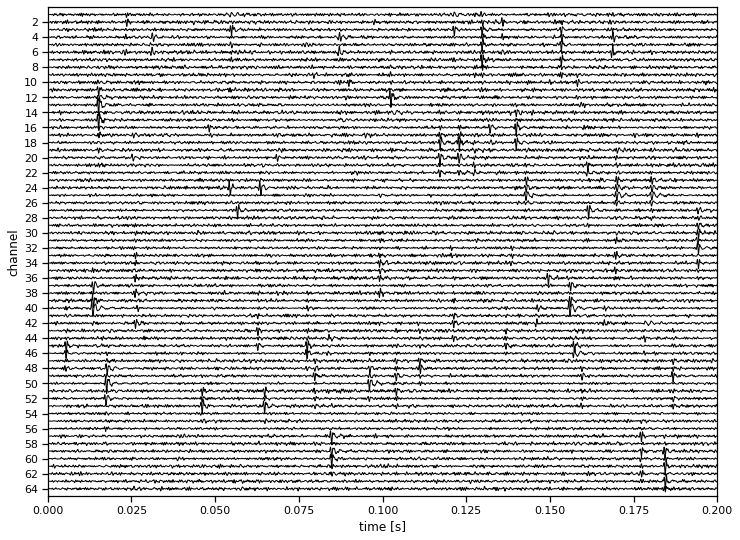

In [ ]:
# Set some constants
sample_freq = 30000           # sampling frequency
spike_width = 81              # width of a spike, in samples
plot_slice = slice(0, 6000)   # 200ms window of frames to plot

# Load the clustering results
with open("lab1_results.pkl", "rb") as f:
    latents, params, hypers = pickle.load(f)
num_neurons = hypers["num_neurons"]

# Load the data and plot it
data = np.load("lab1_preprocessed_data.npy")
num_channels, num_samples = data.shape
timestamps = np.arange(num_samples) / sample_freq
plot_data(timestamps, data, scale=10, plot_slice=plot_slice)

## Fit the model using the fast MAP estimation code from Part 3
This should still take about 4.5 minutes when initialized with random templates. You could also initialize with the results from Lab 1; in fact, this is what Kilosort v1 did. (The latest version has a slightly different approach.) If you dare, try running the "slow" code from Part 2. It should be about 20x slower, so you saved an hour by implementing Part 3! 

Convergence detected!


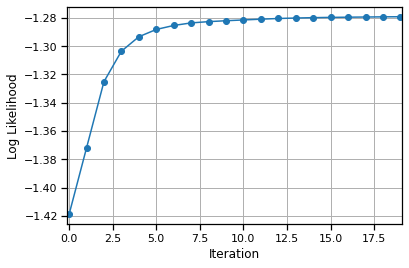

In [ ]:
# Initialize the templates randomly
rng = np.random.default_rng(0)
templates = generate_templates(rng, num_channels, spike_width, num_neurons)

# Instead, you could use the templates from the mixture model fit in Lab 1
# templates_t = to_t(params["templates"])

# Copy to GPU
templates_t = to_t(templates)
amplitudes_t = torch.zeros(num_neurons, num_samples, device=device, dtype=dtype)
data_t = to_t(data)

# Fit the model.
lls = map_estimate_fast(rng, templates_t, amplitudes_t, data_t, noise_std=1.0, amp_rate=10.0)

# If you dare, run the "slow" code for comparison...
# lls = map_estimate(rng, templates_t, amplitudes_t, data_t, 
#                    noise_std=1.0, amp_rate=10.0)

# Get the results off the GPU
templates = from_t(templates_t)
amplitudes = from_t(amplitudes_t)

# Plot the log likelihoods
plt.plot(lls, '-o')
plt.xlabel("Iteration")
plt.xlim(-.1, len(lls) - .9)
plt.ylabel("Log Likelihood")
plt.grid(True)

## Plot the inferred templates

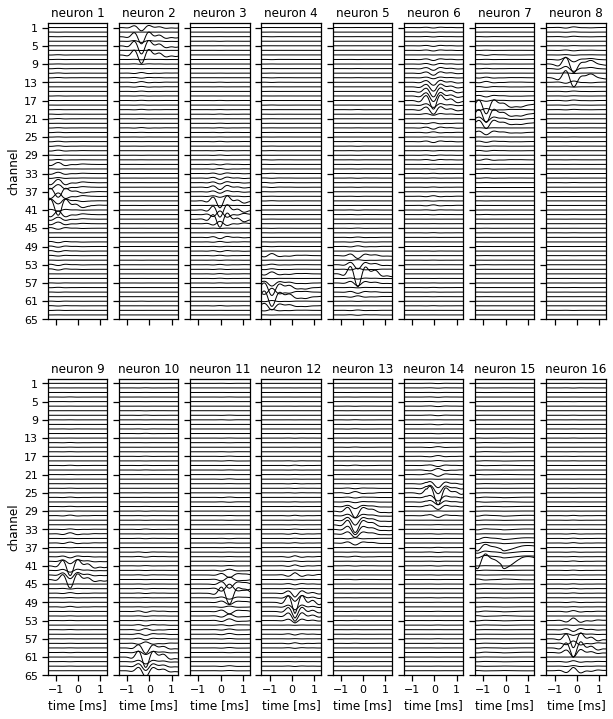

In [ ]:
# Plot some templates (note, they're not ordered in any way)
_ = plot_templates(templates, np.arange(16))

## Plot the data with inferred spikes overlaid
This doesn't show the ground truth, but you should see that the algorithm has picked up the major spikes in the voltage, and it has assigned similar spikes to the same neuron (colors). 


Found 89802 putative spikes


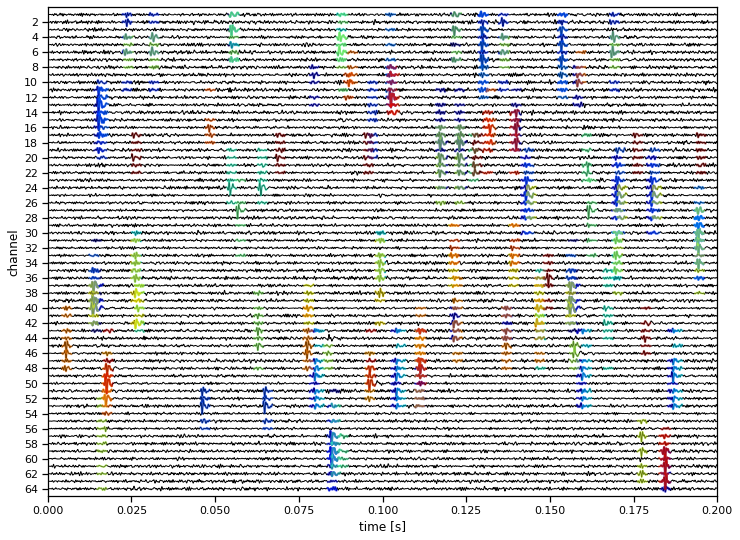

In [ ]:
# Find the spike times and neuron labels
spike_times = []
labels = []
for neuron in trange(num_neurons):
    times = np.where(amplitudes[neuron])[0]
    spike_times.append(times)
    labels.append(neuron * np.ones(len(times), dtype=int))

spike_times = np.concatenate(spike_times)
labels = np.concatenate(labels)

# Find the channels that are significantly modulated in each template
neuron_channels = []
for template in templates:
    thresh = np.percentile(abs(template), 97.5)
    neuron_channels.append(np.any(abs(template) > thresh, axis=1))

print("Found {} putative spikes".format(len(spike_times)))

# Plot the data and overlay the inferred spikes
plot_data(timestamps, data, 
          labels=labels, 
          spike_times=spike_times, 
          neuron_channels=neuron_channels, 
          spike_width=spike_width)

## Problem 4a: Discussion
This is an open-ended question so there's not necessarily a right answer.  We just want you to think critically about the algorithm and the results. Please respond to the following prompts:

- In practice, you would post-process the extracted spikes to reject unrealistic neurons and merge overlapping ones. How would you approach this problem. 
- Over the course of a long recording session, the probe could drift up and down so that the channels activated by a neuron shift. How could you compensate for this slow drift in this model, or possibly try to correct for it during preprocessing?
- How do you expect the computational complexity of your algorithm to scale with the key parameters $(T, D, C, N, K)$? Based on the runtime for this relatively small dataset in Part 4, what runtime would you expect for an hour long recording with 384 channels (as in a real Neuropixels probe)? Are there other computational concerns you might worry about as you scale to much longer recordings?

*Answer below this line*

---
Given the spike timings and amplitudes, some of the same metrics that were used to evaluate last week's results might be used. We might first look at the amplitude distributions of each neuron, to see if they are unimodal. Bimodal/multimodal distributions might indicate assigning more than one neuron to a label of one neuron. We can also look at the inter-spike intervals to see if they are biologically consistent. When looking at the template/spike times, looking to see if neurons that are labeled as distinct actually have very similar spike times and waveforms could tell if we have duplicated the assignment of neurons. Finally we might look at the variance or standard deviation of each waveform and reject those that are outside of a specific range.

The drifting of the probe within the tissue might result in the same neurons being picked up by different channels, or the voltage from a particular neuron changing over time. One approach would be, at a high level, to apply drift correction in a similar way to how motion correction is applied for calcium imaging data. This may involve partitioning the recording time into windows and tracking some statistic between these time windows that could help us determine when drift has occured. Perhaps we could track how a neuron's spike compares to its original template over time as well as the amplitude of the spike on that specific channel. Then, for the relevant time windows, we could shift channels around to account for the changing position of the channels in the neural tissue. 

The computational complexity of the algorithm will scale linearly with the key parameters of the model. The dominating computation in this algorithm is the convolution which scales roughly linearly with each of these components. The rank of the template as well as the number of channels may be the most important factors. As we scale to much longer recordings and more channels, the dimensionality of the data becomes much larger and the recordings become sparser, so a lot of the data is not necessarily useful. We could use dimensionality reduction techniques when processing data of much higher dimensions to simplify our data for more efficient analysis.





# Submission instructions
- Print to PDF and download an .ipynb file. 
- Submit both on GradeScope